# Landscape elevational connectivity 

In [3]:
import time
import numpy as np
import pandas as pd
import cmocean as cmo
from skimage import graph
import bioLEC as lec
from pyevtk.hl import gridToVTK

import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = FutureWarning)

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [6]:
!pwd

/live/share/bioLEC/bioLEC-src/bioLEC/Notebooks/notebooks


Here we illustrate in a _jupyter notebook_ the main steps to compute the **landscape elevational connectivity** described in Bertuzzo et al. (2016) using our developed parallel LECmetrics python code. 

Notebooks environment will not be the best option for large landscape models and we will recommand the use of the python script: `runLEC.py` in HPC environment. the code will need to be 

```bash
mpirun -np 400 python runLEC.py 
```

***

<img src="../images/fig1.png" alt="LEC values" width="800" height="400"/>


***

<div class="alert alert-block alert-info">E. Bertuzzo, F. Carrara, L. Mari, F. Altermatt, I. Rodriguez-Iturbe & A. Rinaldo - Geomorphic controls on species richness. **PNAS**, 113(7) 1737-1742, [DOI: 10.1073/pnas.1518922113](http://www.pnas.org/content/113/7/1737), 2016.</div>

## LEC class initialisation

Initialization function for building landscape elevational connectivity.


### Parameters

+ filename: file name containing regularly spaced elevation grid
+ periodic: applied periodic boundary to the elevation grid
+ symmetric: applied symmetric boundary to the elevation grid
+ sigmap: species niche width percentage based on elevation extent
+ sigmav: species niche fixed width values
+ connected: if `True`, computes the path based on the diagonal moves as well as the axial ones
+ delimiter: delimiter between X,Y,Z coordinates for elevation file (_filename_)
+ header: define position of the header (0 meaning top row) if there is no header use `None`

In [7]:
biodiv = lec.landscapeConnectivity(filename='../dataset/dem.csv',periodic=False,symmetric=False,
                 sigmap=0.1,sigmav=None,delimiter=',',header=0)

_Visualisation of elevation map_

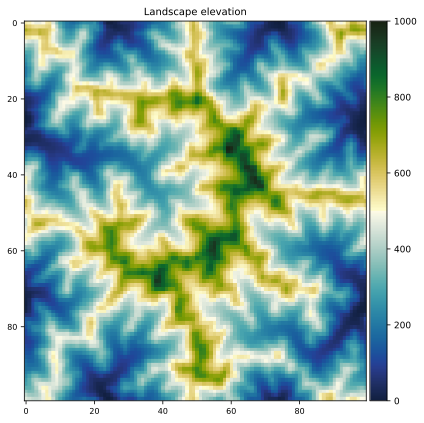

In [8]:
save = None
fig = plt.figure(figsize=(6,6))
ax1 = plt.gca()

ax1.set_title('Landscape elevation', fontsize=10)
im1 = plt.imshow(np.flipud(biodiv.data), vmin=biodiv.data.min(), vmax=biodiv.data.max(), 
                 cmap=cmo.cm.delta, aspect='auto')

ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1,cax=cax1)
cbar1.ax.tick_params(labelsize=9) 

plt.tight_layout()
plt.show()
if save is not None:
    fig.savefig(save,dpi=200, bbox_inches='tight')

## Computing landscape elevational connectivity

In [10]:
time0 = time.clock()
biodiv.computeLEC(fout=500)
print 'Compute LEC function took ',time.clock()-time0

('RUN - rank ', 0, ' start ID ', 0, ' end ID ', 100)
('Rank: ', 0, '  - Compute Cij ', 1.881087, ' step ', 500, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.8151729999999997, ' step ', 1000, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.7989510000000006, ' step ', 1500, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.7819599999999998, ' step ', 2000, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.791917999999999, ' step ', 2500, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.8103540000000002, ' step ', 3000, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.8380459999999985, ' step ', 3500, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.7963120000000004, ' step ', 4000, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.8388279999999995, ' step ', 4500, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.8480430000000005, ' step ', 5000, ' out of ', 10000)
('Rank: ', 0, '  - Compute Cij ', 1.8381809999999987, ' step ', 5500,

_Visualisation of landscape elevational map_

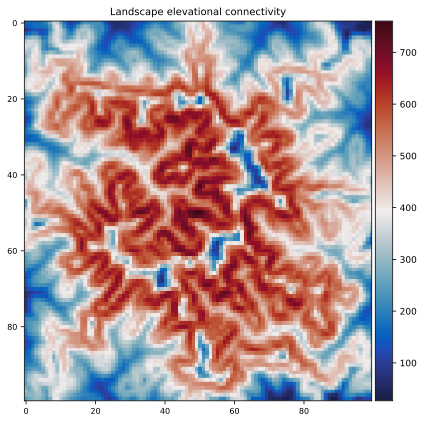

In [11]:
save = None
fig = plt.figure(figsize=(6,6))
ax1 = plt.gca()

ax1.set_title('Landscape elevational connectivity', fontsize=10)
im1 = plt.imshow(np.flipud(biodiv.LEC), vmin=biodiv.LEC.min(), vmax=biodiv.LEC.max(), 
                 cmap=cmo.cm.balance, aspect='auto')

ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1,cax=cax1)
cbar1.ax.tick_params(labelsize=9) 

plt.tight_layout()
plt.show()
if save is not None:
    fig.savefig(save,dpi=200, bbox_inches='tight')

## Write LEC data

In [13]:
time0 = time.clock()
biodiv.writeLEC('LEC.csv')
if biodiv.rank == 0:
    print 'Output function took ',time.clock()-time0

Output function took  0.071949


# Data transformation & analysis

First we open the _elevation_ (`dem.csv`) and the _LEC_ (`LEC.csv`) files and create a new file (`combined.csv`)  that combines both dataset.

In [14]:
folder = '../dataset'
file1 = folder+'/dem.csv'
file2 = 'LEC.csv'
outfile = 'combined.csv'

First file:

In [15]:
df = pd.read_csv(file1, sep=',', engine='c',
                header=0, na_filter=False, dtype=np.float,
                low_memory=False)
X = df['X']
Y = df['Y']
Z = df['Z']

dx = ( X[1] - X[0] )
nx = int((X.max() - X.min())/dx+1)
ny = int((Y.max() - Y.min())/dx+1)

Second file:

In [16]:
df2 = pd.read_csv(file2, sep=',', engine='c',
                header=0, na_filter=False, dtype=np.float,
                low_memory=False)
LEC = df2['LEC']

We now write the combined dataset file:

In [17]:
X = np.reshape(X,(ny,nx))
Y = np.reshape(Y,(ny,nx))
Z = np.reshape(Z,(ny,nx))
LEC = np.reshape(LEC,(ny,nx))

df3 = pd.DataFrame({'X':X.flatten(),'Y':Y.flatten(),
                    'Z':Z.flatten(),'LEC':LEC.flatten()})    
df3.to_csv(outfile, columns=['X', 'Y', 'Z', 'LEC'], sep=',', index=False , header=1)

Now we create a **VTK** file for quick visualisation in _Paraview_...

In [18]:
vtkfile = folder+'/grid'

Xv = np.zeros((X.shape[0],X.shape[1],2))
Yv = np.zeros((X.shape[0],X.shape[1],2))
Zv = np.zeros((X.shape[0],X.shape[1],2))
LECv = np.zeros((X.shape[0],X.shape[1],2))
normLEC = np.zeros((X.shape[0],X.shape[1],2))

Xv[:,:,0] = X
Yv[:,:,0] = Y
Zv[:,:,0] = Z
LECv[:,:,0] = LEC
normLEC[:,:,0] = LEC/LEC.max()

Xv[:,:,1] = X
Yv[:,:,1] = Y
Zv[:,:,1] = Z
LECv[:,:,1] = LEC
normLEC[:,:,1] = LEC/LEC.max()

gridToVTK(vtkfile, Xv, Yv, Zv, pointData = {"elevation" : Zv, "LEC" :LECv, "nLEC" :normLEC})

'/live/share/bioLEC/bioLEC-src/bioLEC/Notebooks/dataset/grid.vts'

## Plotting elevation and LEC distribution

_Elevation frequency as function of site elevation_

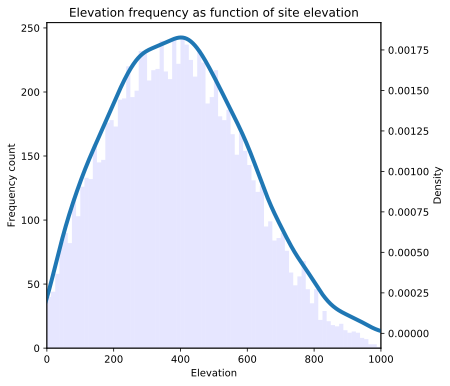

In [20]:
folder = 'dataset'
basinfile = 'combined.csv'

data = pd.read_csv(basinfile)

ax = data.Z.plot(kind='hist', color='Blue', alpha=0.1, bins=80, xlim=(data.Z.min(),data.Z.max()))
plt.xlabel('Elevation')
data.Z.plot(kind='density', figsize=(6,6), ax=ax, xlim=(data.Z.min(),data.Z.max()),
               linewidth=4,title='Elevation frequency as function of site elevation',secondary_y=True,y='Density')
ax.set_ylabel('Frequency count')
plt.ylabel('Density')
plt.show()

_Landscape elevational connectivity as a function of elevation_

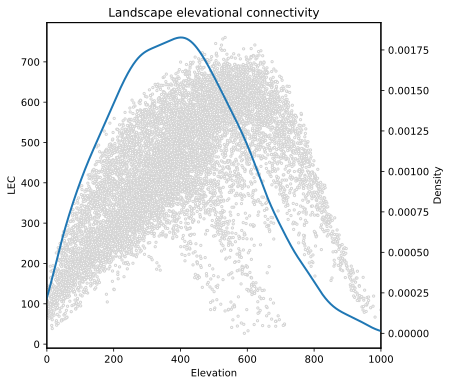

In [21]:
ax = data.plot(kind='scatter', x='Z', y='LEC', c='white', edgecolors='lightgray', figsize=(6,6), 
          xlim=(data['Z'].min(),data['Z'].max()), s=5, title='Landscape elevational connectivity')
plt.xlabel('Elevation')
ax2=ax.twinx()  
data.Z.plot(kind='density',secondary_y=True, ax=ax2, xlim=(data['Z'].min(),data['Z'].max()),
               linewidth=2)
ax.set_ylabel('LEC')
plt.ylabel('Density')
plt.show()

_Combined plot_

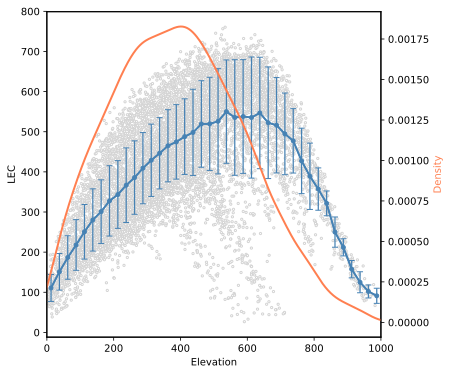

In [22]:
nbins = 40
fig, ax = plt.subplots(figsize=(6, 6))

w = data.LEC
n, _ = np.histogram(data.Z, bins=nbins)
sy, _ = np.histogram(data.Z, bins=nbins, weights=w)
sy2, _ = np.histogram(data.Z, bins=nbins, weights=w*w)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.ylabel('LEC')
plt.xlabel('Elevation')

plt.plot((_[1:] + _[:-1])/2, mean,color='steelblue',zorder=2,linewidth=2)
plt.scatter(data.Z, w, c='w',edgecolors='lightgray', zorder=0,alpha=1.,s=5)
ax.set_xlim(data.Z.min(),data.Z.max())

(_, caps, _) = plt.errorbar(
    (_[1:] + _[:-1])/2, mean, yerr=std, fmt='-o', c='steelblue',markersize=4, capsize=3,zorder=1,linewidth=1.25)

for cap in caps:
    cap.set_markeredgewidth(1)


ax2=ax.twinx()  
data.Z.plot(kind='density',secondary_y=True, ax=ax2, xlim=(data.Z.min(),data.Z.max()),
               color='coral',linewidth=2,zorder=0)
 

plt.ylabel('Density', color='coral')
plt.show()

## Testing Graph connectivities and boundary conditions on LEC calculation 

***

<img src="../images/fig2.png" alt="LEC values" width="800" height="800"/>


***

## Impact of grid resolution on LEC calculation 

***

<img src="../images/fig3.png" alt="LEC values" width="800" height="800"/>


***